## Miksi?

big_fit.csv ei sisältänytkään kaikkia cross validation fittien mallien parametreja, vaan taulukot oli typistetty ... -merkinnöillä.

## Mitä?

1. Ladataan jo fitatut mallit all_fitted_models.pkl:stä 
2. Valitaan plotattavat cross-val mallit ja dateasetit
3. Ajetaan k-fold_cv uudestaan valituille malleille
4. Tallennetaan mallit oikein käyttäen prophetin model_to_json

Relevantissa notebookissa sit plotataan näiden perusteella cross-val plotit

In [93]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from prophet.python import fbprophet
from prophet.python.fbprophet import models
from prophet.python.fbprophet import plot
from prophet.python.fbprophet import diagnostics
from prophet.python.fbprophet.serialize import model_to_json, model_from_json
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm

import metrics_refactored

from make_datasets import data, datasets, format_for_prophet, dataset_generator

In [4]:
all_fitted_models = pd.read_pickle('../all_fitted_models.pkl')

In [8]:
 to_refit = all_fitted_models.iloc[[0, 1, 2, 3, 4]]

In [9]:
to_refit['model'] = to_refit['model'].apply(model_from_json)

Importing plotly failed. Interactive plots will not work.


In [29]:
from metrics_refactored import prophet_copy, predict_with_samples, lppd

In [33]:
fit_kwargs = {'adapt_delta': 0.9, 'max_treedepth': 11, 'adapt_kappa': 0.75}

In [53]:
def k_fold_loo_cv(model, k=10):  # Oletetaan, että residuaalit iid
    og_lppd = lppd(model)
    data = model.history.sample(frac=1).reset_index(drop=True)  # shuffle
    breakpoints = np.linspace(0, data.shape[0], k+1, endpoint=True).astype(int)

    #scipy.stats.norm.pdf(p, loc=df['y'].values, scale=m1.params['sigma_obs'][:, np.newaxis])  # TODO: muista skaalaus
    def train_test_split(i):  # OK
        test = data[breakpoints[i]:breakpoints[i+1]].sort_values(by='t')#.reset_index().drop(columns='index')
        train = data.drop(test.index, axis=0).sort_values(by='t').reset_index(drop=True)
        test = test.reset_index(drop=True)
        return (train, test) 

    res = 0
    lppds = []
    params = []
    runs = []
    for i in range(k):
    #for i in tqdm.tqdm(range(k)):
        #print(f'CV {i}')
        train, test = train_test_split(i)
        clean_model = prophet_copy(model)
        fit = clean_model.fit(train, control=fit_kwargs)  # Voiko olla ongelma, että t scale muuttuu?
        params.append(fit.params.copy())
        runs.append({'model_string': model_to_json(fit), 'train_data': train, 'test_data': test})
        p = predict_with_samples(fit, test)  
        lik = scipy.stats.norm.pdf(p/fit.y_scale, loc=test['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis]) # OK
        res += np.log(lik.prod(axis=1).mean())  # OK

        #p_i = predict_with_samples(fit, model.history)
        #b_lik = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=model.history['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
        #lppd_i = np.log(b_lik.prod(axis=1).mean())
        #mean_lppd_i += np.log(b_lik.prod(axis=1).mean())/k  # Taitaa olla väärin
        lppd_i = 0
        for j in range(k):
            #print(f'lppd {j}')
            train_i, test_i = train_test_split(j)
            p_i = predict_with_samples(fit, test_i)
            lik_i = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=test_i['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
            lppd_i += np.log(lik_i.prod(axis=1).mean())
        lppds.append(lppd_i)

    mean_lppd_i = sum(lppds) / k

    bias = og_lppd - mean_lppd_i
    lppd_bias_corrected = res + bias
    eff_params = mean_lppd_i - res
    return {'value': lppd_bias_corrected, 'aux':{'lppd_loo_cv': res, 'bias': bias, 'p_cloo': eff_params, 'fitted_params':params, 'runs': runs}}


In [90]:
test_model = to_refit.iloc[1]['model']
out = k_fold_loo_cv(test_model, k=10)

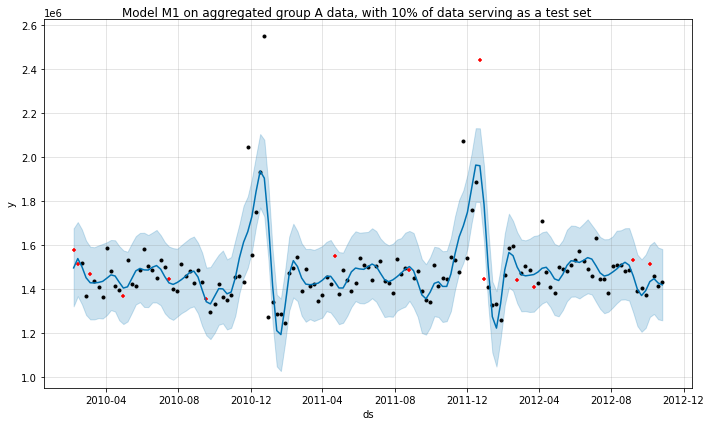

In [75]:

run = out['aux']['runs'][0]
cv_model = model_from_json(run['model_string'])
test = run['test_data']
future = test_model.make_future_dataframe(periods=0)
prediction = cv_model.predict(future)
fig = cv_model.plot(prediction)
fig.axes[0].scatter(test['ds'], test['y'], color='red', marker='+', s=10)
fig.suptitle('Model M1 on aggregated group A data, with 10% of data serving as a test set')
fig.savefig('../plots/forecasts/cv_metric_demo_plot.pdf')

In [82]:
test.shape[0]

30

In [91]:
forecasting_model = prophet_copy(test_model)
cutoff_index = -30
train = test_model.history.iloc[:cutoff_index]
test = test_model.history.iloc[cutoff_index:]
fit = forecasting_model.fit(train, control=fit_kwargs)
future = fit.make_future_dataframe(periods=test.shape[0]*7)
prediction = fit.predict(future)
fig = fit.plot(prediction)
fig.axes[0].scatter(test['ds'], test['y'], color='red', marker='+', s=10)
fig.suptitle('M1 store group A prediction 30 weeks in the future')
fig.savefig('../plots/forecasts/30_weeks_prediction_demo.pdf')

ValueError: Regressor 'temperature' missing from dataframe

In [ ]:
fig = fit.plot_components(prediction)
fig.suptitle('Components of the 30 week prediction')
fig.savefig('../plots/forecasts/30_weeks_prediction_components_demo.pdf')

In [67]:
out['aux']['runs'][0]['test_data']

,ds,temperature,fuel_price,cpi,unemployment_interpolated,y,IsHoliday,overfit,floor,t,y_scaled
0,2010-02-05,33.690032,2.703840,170.722140,8.453469,1.576715e+06,False,0.600881,0,-0.014286,0.618352
1,2010-02-12,32.856791,2.685976,170.819624,8.433678,1.516366e+06,True,0.597043,0,-0.007143,0.594685
2,2010-03-05,42.054062,2.724567,170.943267,8.374303,1.468024e+06,False,0.583209,0,0.014286,0.575726
3,2010-04-30,57.171320,2.876192,170.567289,8.266451,1.368226e+06,False,0.558052,0,0.071429,0.536588
4,2010-07-16,79.748539,2.746773,170.956284,8.207994,1.446138e+06,False,0.556790,0,0.150000,0.567143
5,2010-09-17,70.711442,2.714614,171.275701,8.235373,1.354075e+06,False,0.546827,0,0.214286,0.531038
6,2011-04-22,58.827646,3.854408,174.177783,7.913708,1.551338e+06,False,0.571364,0,0.435714,0.608400
7,2011-08-26,79.729997,3.634845,175.038406,7.742588,1.489363e+06,False,0.539552,0,0.564286,0.584095
8,2011-12-23,39.152309,3.275509,177.015462,7.399950,2.439795e+06,False,0.978084,0,0.685714,0.956833
9,2011-12-30,37.543880,3.262452,177.143684,7.379120,1.447923e+06,True,0.578242,0,0.692857,0.567843


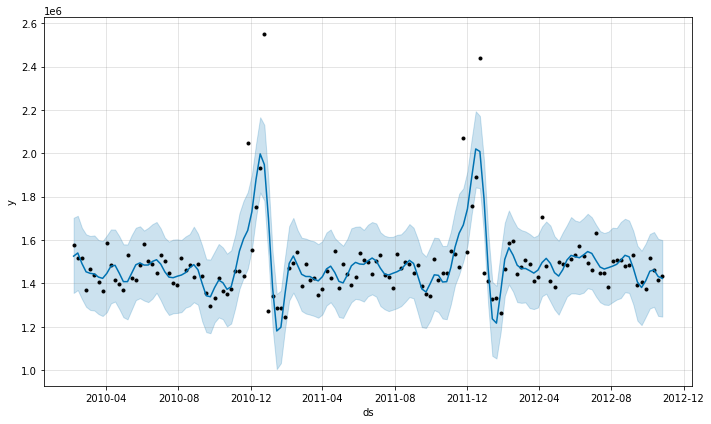

In [65]:
future = test_model.make_future_dataframe(periods=0)
prediction = test_model.predict(future)
ax = test_model.plot(prediction)
ax.plot(out[])

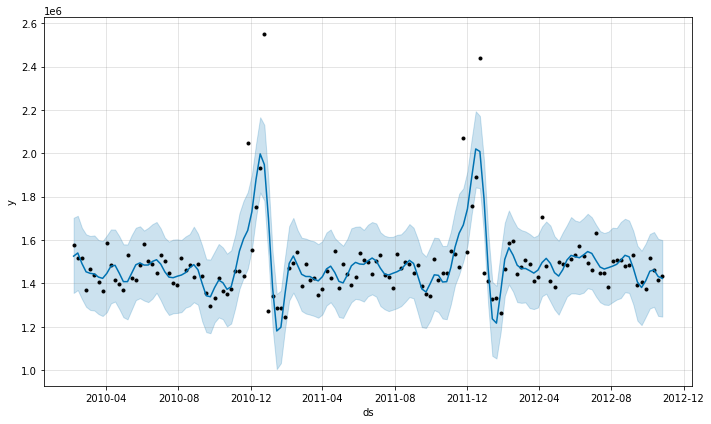

In [46]:
len(out['aux']['fitted_params'][0]['k'])

2000

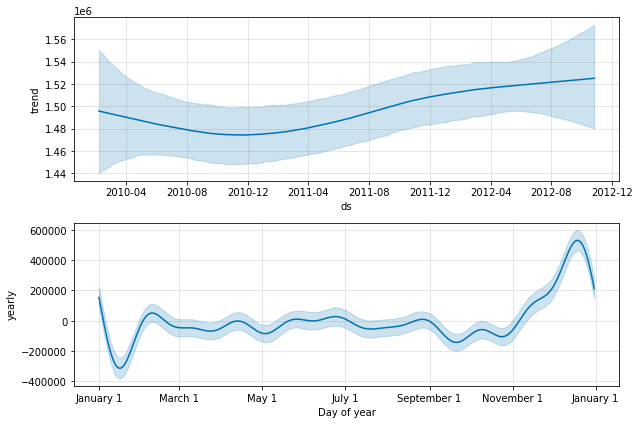

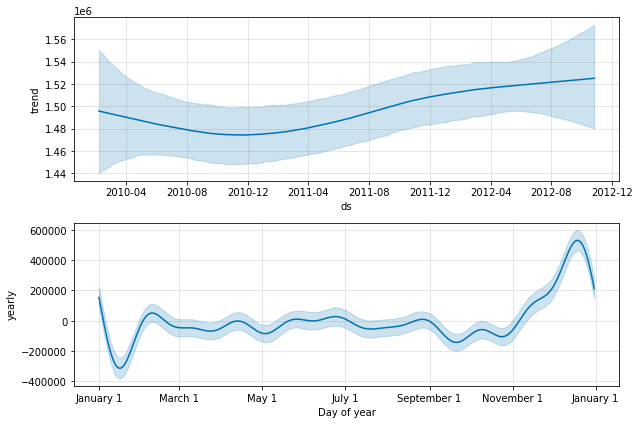

In [24]:
test_model.plot_components(test_model.predict(test_model.make_future_dataframe(0)))

In [28]:
model = fbprophet.Prophet()